In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Data Loading and Imports

In [2]:
# !pip install xgboost


train=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')


import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV , RepeatedStratifiedKFold ,cross_val_score, StratifiedKFold ,train_test_split


from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay ,f1_score

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import xgboost 
import xgboost as xgb_import




# Shape of train data and test data

In [3]:
print("Shape of train data",train.shape)
print("----------------------------------------")
print("")
print("Shape of train data",test.shape)
print("----------------------------------------")



Shape of train data (39211, 16)
----------------------------------------

Shape of train data (10000, 15)
----------------------------------------


In [4]:
print("Traget Values of train")
print("----------------------------------------")


print(train['target'].value_counts())

print("----------------------------------------")
print("")


Traget Values of train
----------------------------------------
target
no     33384
yes     5827
Name: count, dtype: int64
----------------------------------------



# Train data and Test data

In [5]:
train.head(5)


,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [6]:
test.head(5)


,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


# Null values that each column is having

In [7]:
print("Train Data")
print("-------------------------------------------")
print(train.isnull().sum())
print("")
print("-------------------------------------------")
print("-------------------------------------------")
print("")
print("Test Data")
print("-------------------------------------------")
print(test.isnull().sum())


Train Data
-------------------------------------------
last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

-------------------------------------------
-------------------------------------------

Test Data
-------------------------------------------
last contact date       0
age                     0
job                    59
marital                 0
education             390
default                 0
balance                 0
housing                 0
loan                    0
contact              2684
duration                0
campaign                0
pdays                   0
previous          

# Last Contact and Feature engineering


In [8]:
train['last contact date']=pd.to_datetime(train['last contact date'])

train['day']= train['last contact date'].dt.dayofweek

train['month'] = train['last contact date'].dt.month

print(train['month'].value_counts())

print('')
print('--------------------------')

print(train['day'].value_counts())




test['last contact date']=pd.to_datetime(test['last contact date'])

test['day']= test['last contact date'].dt.dayofweek

test['month'] = test['last contact date'].dt.month



month
5     11004
7      5521
8      4969
6      4232
11     3147
4      2359
2      2087
1      1725
10     1236
9      1091
3       997
12      843
Name: count, dtype: int64

--------------------------
day
3    7428
2    7292
4    6762
1    6184
5    4496
0    4033
6    3016
Name: count, dtype: int64


# WeekDay or Sunday -Feature Engineering:that helps us to know if the day was sunday or week Day

In [9]:
def whichday(x):
    if x==1:
        return 1
    return 0
train['isSunday']=train['day'].apply(whichday)

test['isSunday']=test['day'].apply(whichday)

# Categorical Columns
# job , martial , education , default , housing ,loan , contact , poutcome

# Job


 Number of null values :  229

---------------------------------------------------------------------------

Unique job :  ['blue-collar' 'technician' 'admin.' 'entrepreneur' 'unemployed'
 'management' 'services' 'student' 'self-employed' 'retired' 'housemaid'
 nan]

---------------------------------------------------------------------------

job value counts:  job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64

---------------------------------------------------------------------------



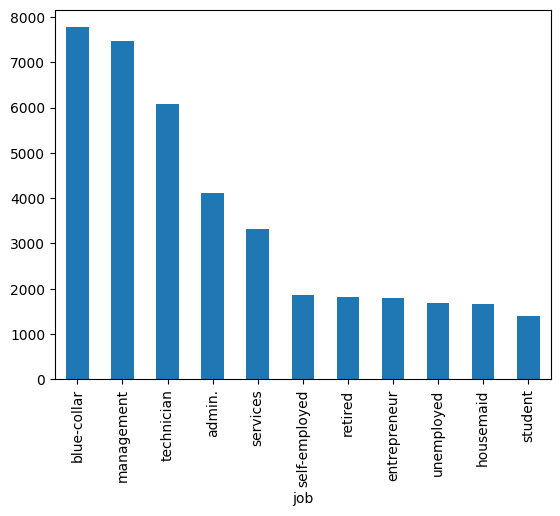


---------------------------------------------------------------------------



In [10]:

print(' Number of null values : ' , train['job'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print('Unique job : ' , train['job'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('job value counts: ' , train['job'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['job'].value_counts().plot(kind='bar')
plt.show()

print('')
print('---------------------------------------------------------------------------')
print('')


train['job'] = train['job'].replace(np.nan, 'blue-collar')
test['job'] = test['job'].replace(np.nan , 'blue-collar')

# martial

marital has no null values :  0

---------------------------------------------------------------------------

 Unique marital :  ['married' 'single' 'divorced']

---------------------------------------------------------------------------

marital value counts:  marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64

---------------------------------------------------------------------------



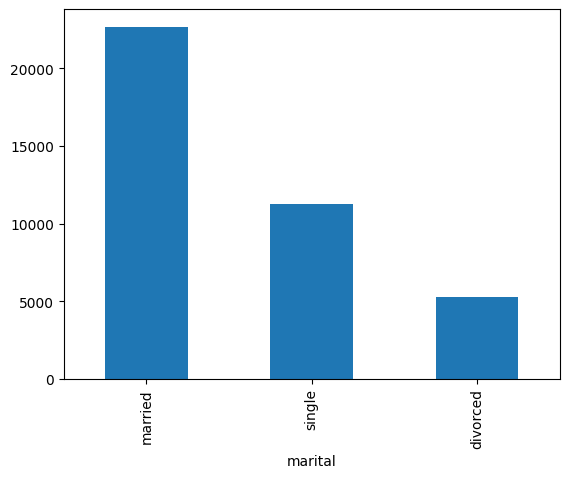

In [11]:
print('marital has no null values : ' , train['marital'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique marital : ' , train['marital'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('marital value counts: ' , train['marital'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['marital'].value_counts().plot(kind='bar')
plt.show()

# education

education has no null values :  1467

---------------------------------------------------------------------------

 Unique education :  ['secondary' 'tertiary' 'primary' nan]

---------------------------------------------------------------------------

education value counts:  education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64

---------------------------------------------------------------------------



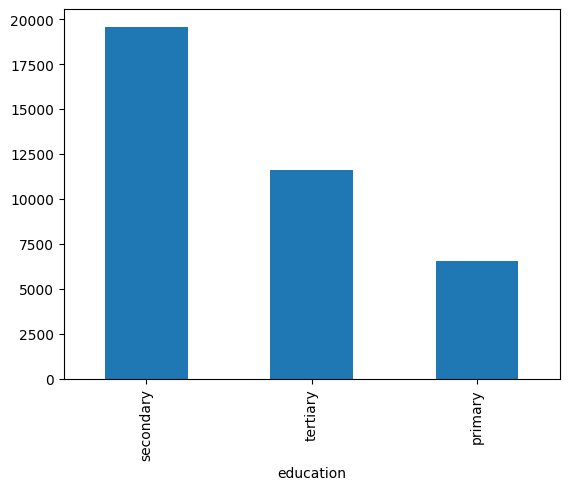

In [12]:
print('education has no null values : ' , train['education'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique education : ' , train['education'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('education value counts: ' , train['education'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['education'].value_counts().plot(kind='bar')


train['education']=train['education'].replace(np.nan , 'secondary')

test['education']=test['education'].replace(np.nan , 'secondary')

# default


default has no null values :  0

---------------------------------------------------------------------------

 Unique default :  ['no' 'yes']

---------------------------------------------------------------------------

default value counts:  default
no     36954
yes     2257
Name: count, dtype: int64

---------------------------------------------------------------------------



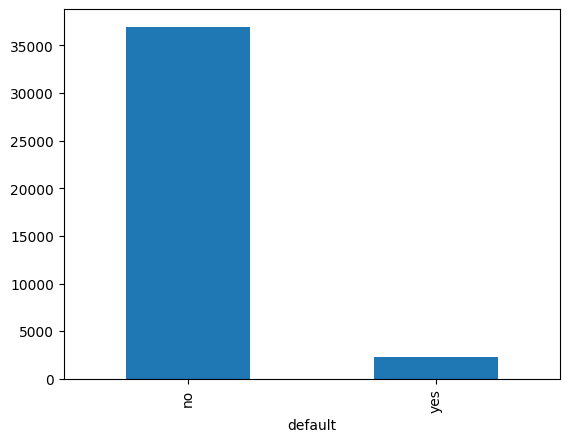

In [13]:
print('default has no null values : ' , train['default'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique default : ' , train['default'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('default value counts: ' , train['default'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['default'].value_counts().plot(kind='bar')
plt.show()


train['default'] = train['default'].map({'no': 0, 'yes': 1})


test['default'] = test['default'].map({'no': 0, 'yes': 1})


# housing

housing has no null values :  0

---------------------------------------------------------------------------

 Unique housing :  ['yes' 'no']

---------------------------------------------------------------------------

housing value counts:  housing
yes    21657
no     17554
Name: count, dtype: int64

---------------------------------------------------------------------------



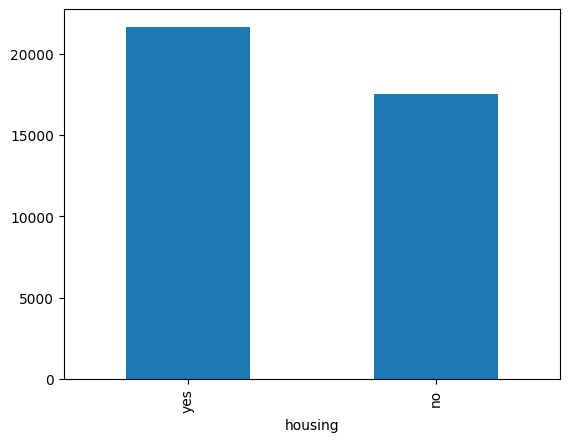

In [14]:
print('housing has no null values : ' , train['housing'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique housing : ' , train['housing'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('housing value counts: ' , train['housing'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['housing'].value_counts().plot(kind='bar')
plt.show()

train['housing'] = train['housing'].map({'no': 0, 'yes': 1})



test['housing'] = test['housing'].map({'no': 0, 'yes': 1})


loan has no null values :  0

---------------------------------------------------------------------------

 Unique loan :  ['no' 'yes']

---------------------------------------------------------------------------

loan value counts:  loan
no     31820
yes     7391
Name: count, dtype: int64

---------------------------------------------------------------------------



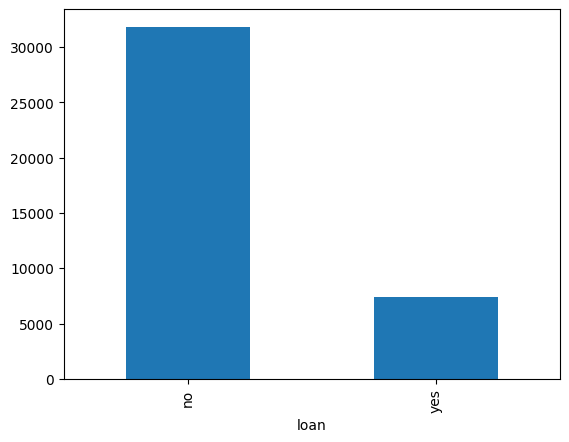

In [15]:
print('loan has no null values : ' , train['loan'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique loan : ' , train['loan'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('loan value counts: ' , train['loan'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['loan'].value_counts().plot(kind='bar')
plt.show()




train['loan'] = train['loan'].map({'no': 0, 'yes': 1})


test['loan'] = test['loan'].map({'no': 0, 'yes': 1})



contact has null values :  10336

---------------------------------------------------------------------------

 Unique contact :  ['cellular' 'telephone' nan]

---------------------------------------------------------------------------

contact value counts:  contact
cellular     25030
telephone     3845
Name: count, dtype: int64

---------------------------------------------------------------------------



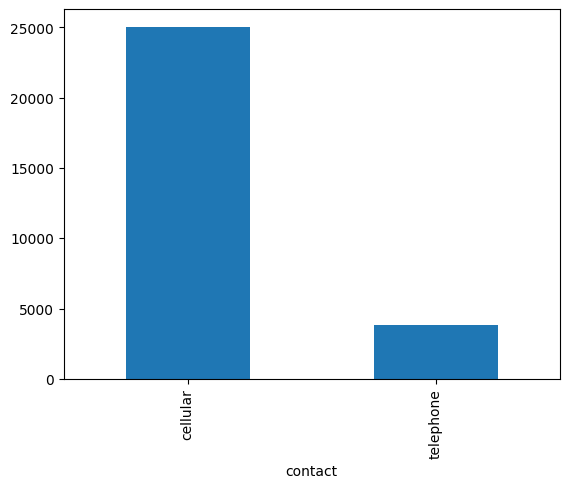

In [16]:
print('contact has null values : ' , train['contact'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique contact : ' , train['contact'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('contact value counts: ' , train['contact'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['contact'].value_counts().plot(kind='bar')
plt.show()


train['contact']=train['contact'].replace(np.nan , 'cellular')

train['contact'] = train['contact'].map({'cellular': 1, 'telephone': 0})



test['contact']=test['contact'].replace(np.nan , 'cellular')
test['contact'] = test['contact'].map({'cellular': 1, 'telephone': 0})



poutcome has  null values :  29451

---------------------------------------------------------------------------

 Unique poutcome :  ['other' nan 'failure' 'success']

---------------------------------------------------------------------------

poutcome value counts:  poutcome
failure    4949
other      2560
success    2251
Name: count, dtype: int64

---------------------------------------------------------------------------



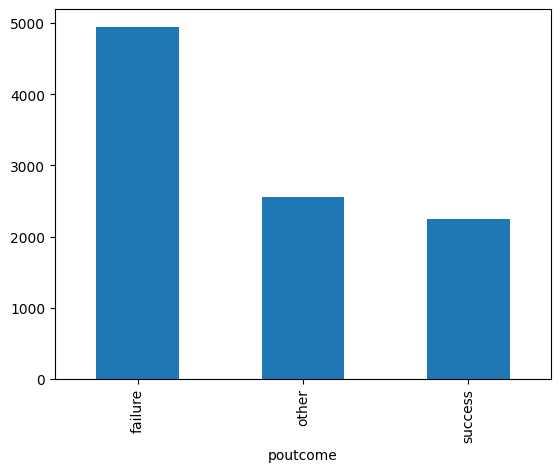

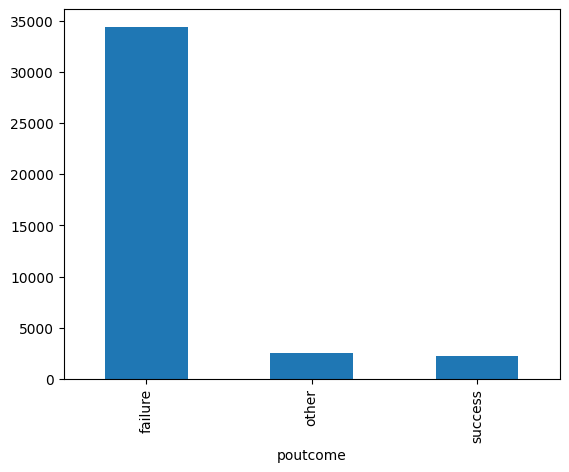

In [17]:
print('poutcome has  null values : ' , train['poutcome'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique poutcome : ' , train['poutcome'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('poutcome value counts: ' , train['poutcome'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')


train['poutcome'].value_counts().plot(kind='bar')
plt.show()



train['poutcome'] = train['poutcome'].replace(np.nan, 'failure')


train['poutcome'].value_counts().plot(kind='bar')
plt.show()



test['poutcome'] = test['poutcome'].replace(np.nan, 'failure')


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   last contact date  39211 non-null  datetime64[ns]
 1   age                39211 non-null  int64         
 2   job                39211 non-null  object        
 3   marital            39211 non-null  object        
 4   education          39211 non-null  object        
 5   default            39211 non-null  int64         
 6   balance            39211 non-null  int64         
 7   housing            39211 non-null  int64         
 8   loan               39211 non-null  int64         
 9   contact            39211 non-null  int64         
 10  duration           39211 non-null  int64         
 11  campaign           39211 non-null  int64         
 12  pdays              39211 non-null  int64         
 13  previous           39211 non-null  int64         
 14  poutco

# Numerical Columns
# Age , Balance , campaign , pdays , previous

Age has no null values :  0

---------------------------------------------------------------------------

no. of age less than zero is  0

---------------------------------------------------------------------------

 Unique Ages :  [26 52 44 33 31 25 46 37 38 32 28 34 86 42 58 39 35 47 45 48 30 50 56 54
 40 53 41 51 27 29 57 63 36 43 19 55 49 23 83 60 22 80 76 59 24 93 71 89
 64 68 85 79 62 69 20 90 66 87 72 88 67 70 77 91 78 61 65 73 74 84 82 92
 81 18 21 75 94 95]

---------------------------------------------------------------------------

Age value counts:  age
32    1688
31    1629
33    1599
35    1571
34    1566
      ... 
18      44
92      41
87      40
85      39
95       2
Name: count, Length: 78, dtype: int64

---------------------------------------------------------------------------



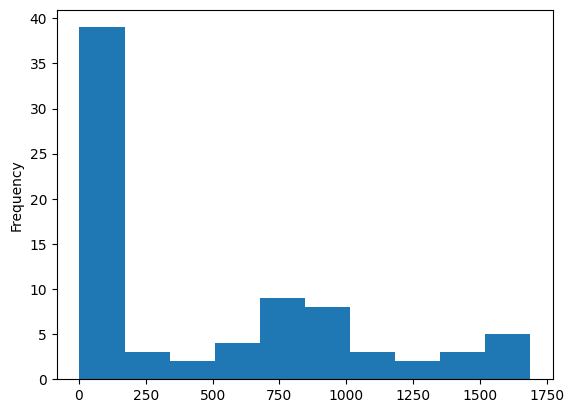

In [19]:
print('Age has no null values : ' , train['age'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print('no. of age less than zero is ', train[train['age']<0]['age'].count())


print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique Ages : ' , train['age'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('Age value counts: ' , train['age'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['age'].value_counts().plot(kind='hist')
plt.show()




# Feature Engineering Age Category

In [20]:
def age_category(x):
    if x<=39:
        return 'young'
    if 40<=x<=59:
        return 'middle'
    return 'old'


train['Age_Category'] = train['age'].apply(age_category)

test['Age_Category'] = test['age'].apply(age_category)



campaign has no null values :  0

---------------------------------------------------------------------------

camaign less than zero is  0

---------------------------------------------------------------------------

 Unique campaign  :  [ 2  1  3  4  6 45  5 44 12 61 58  7  8 20 43 17 13 15 48 34 11 54 22 26
 29 21 10 49  9 52 53 57 16 50 46 47 23 37 18 38 32 36 39 56 14 30 41 63
 51 28 25 62 55 42 35 31 59 19 40 33 24 27 60]

---------------------------------------------------------------------------

campaign value counts:  campaign
1     14013
2     10016
3      4470
4      2861
5      1469
      ...  
48       44
30       43
40       43
60       43
53       38
Name: count, Length: 63, dtype: int64

---------------------------------------------------------------------------



<Axes: ylabel='Frequency'>

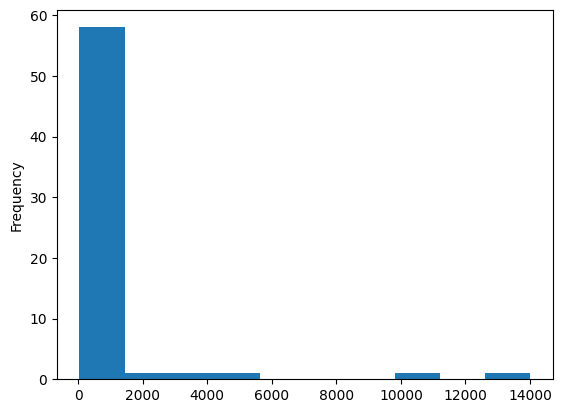

In [21]:
print('campaign has no null values : ' , train['campaign'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')


print('camaign less than zero is ', train[train['campaign']<0]['campaign'].count())


print('')
print('---------------------------------------------------------------------------')
print('')
print(' Unique campaign  : ' , train['campaign'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('campaign value counts: ' , train['campaign'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['campaign'].value_counts().plot(kind='hist')



balance has no null values :  0

---------------------------------------------------------------------------

checking if balance is negetive and how many rows have balance less than zero: 2971

---------------------------------------------------------------------------

 Unique balance values :  [  647   553  1397 ...  4307  6187 38594]

---------------------------------------------------------------------------

balance value counts:  balance
0        2799
1         149
2         122
4         115
3         104
         ... 
95094       1
81074       1
31565       1
5278        1
38594       1
Name: count, Length: 9535, dtype: int64

---------------------------------------------------------------------------



<Axes: ylabel='Frequency'>

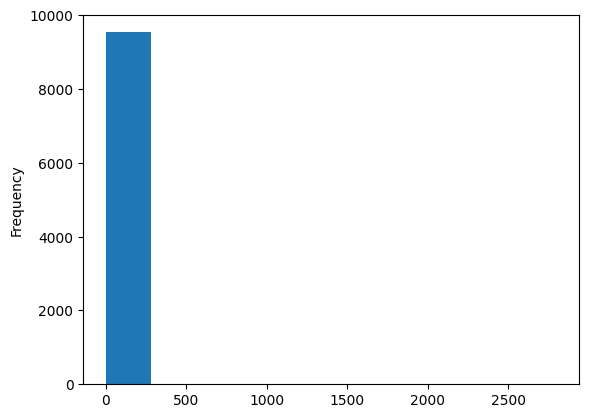

In [22]:
print('balance has no null values : ' , train['balance'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print('checking if balance is negetive and how many rows have balance less than zero:'  , train[train['balance']<0]['balance'].count())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique balance values : ' , train['balance'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('balance value counts: ' , train['balance'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['balance'].value_counts().plot(kind='hist')







pdays has no null values :  0

---------------------------------------------------------------------------

 Unique pdays values :  [331  -1 852 661 152 599 365 367 238 129 287 174 120 368 371 187 610 364
 633  80 125 356 248 186 278 154  90  98 574 352 561 260 801  78 596 343
 671 175 159  12 111  31 342 357  74 100 289  84 109 245 369  83 536 216
  89  97 252 143 378 336 172 160 191  91 848 258 317  94 196 362 188 272
 138 298 116 101 591 360 234 505 631  82   8 300 472 173 530 103 236 316
 370 611 271 305  79 474 405 293 442 178 232 299 213 184 237  93  37 255
 353 259 181 315 147 349 335 165 295 203 290   6 767 302 169 320 148  19
 435 328 645 526 150 318 347  29  96 254  35 136 350 759 358 670 348 224
 114 102 407 326 330 665 760 445 373 265 190 285 246 644 337 161 264 562
 189 363 630 652  44 478 322 176 783 597 344 339 110 334 167 204 166 816
 484 177 775 366  32 480 200 408 421 247 291 261 579 244 730 324 434 525
 156 153 157  95 439 286 163 197 182 309 257 283 461 824  92 704 

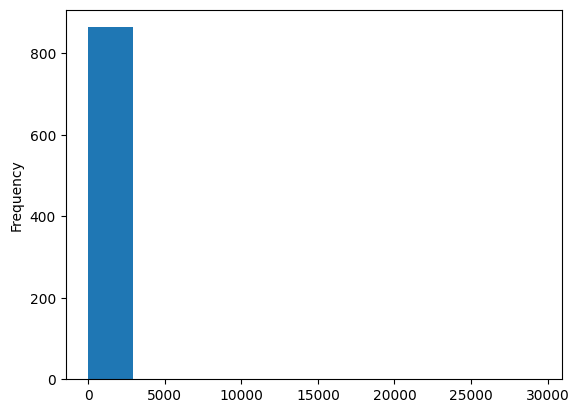

In [23]:
print('pdays has no null values : ' , train['pdays'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique pdays values : ' , train['pdays'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('pdays value counts: ' , train['pdays'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['pdays'].value_counts().plot(kind='hist')



train['previously_contacted'] = train['pdays'].apply(lambda x: 1 if x != -1 else 0)

test['previously_contacted'] = test['pdays'].apply(lambda x: 1 if x != -1 else 0)


previous has no null values :  0

---------------------------------------------------------------------------

checking if previous is negetive and how many rows have previous less than zero: 0

---------------------------------------------------------------------------

 Unique previous  :  [  1   0   4 143 234   3  18   2 225 219   6  12  16 248 217 116   8 119
  37  69 113  14 265 175 103  28  86   5 196 156 207 218 148 213  87 241
  60 235 172 255 266  17 135  99  20   9 270 229 188 105 141 153 131 182
 223 177  70  75   7  91 236  85 100 160  30  63 178 150  72 233  40 145
 272  24 249  97 193 140 222 128  90  10 155 122 134 252 117 173 203 226
  23 194 208  77 274  38 273 244  15 176  96  31 133 259 191 101 197 192
 152 216 204 206  71 180 250 268 144  81 110 136  43  19  74 187 205  66
 269  36 166  29  53 200 261  13  61 186  62 104 138 123  78 189 147 185
 179 129 190 111 139 211 245  22  51 171  26 254  84 174  46  48  58  68
 228  11  80  55 107 232 202 132 264  56 260 181  

<Axes: ylabel='Frequency'>

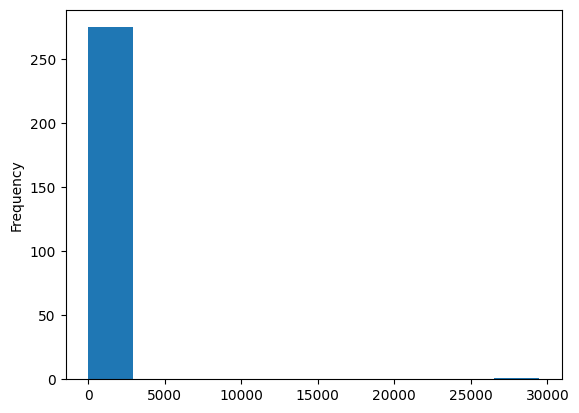

In [24]:
print('previous has no null values : ' , train['previous'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')


print('checking if previous is negetive and how many rows have previous less than zero:'  , train[train['previous']<0]['previous'].count())


print('')
print('---------------------------------------------------------------------------')
print('')


print(' Unique previous  : ' , train['previous'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('previous value counts: ' , train['previous'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['previous'].value_counts().plot(kind='hist')


In [25]:
print('Shape:', train.shape)
print('')
print('---------------------------------------------------------------------------')
print('')
print(train.info())
print('')
print('---------------------------------------------------------------------------')
print('')
train.describe()

Shape: (39211, 21)

---------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   last contact date     39211 non-null  datetime64[ns]
 1   age                   39211 non-null  int64         
 2   job                   39211 non-null  object        
 3   marital               39211 non-null  object        
 4   education             39211 non-null  object        
 5   default               39211 non-null  int64         
 6   balance               39211 non-null  int64         
 7   housing               39211 non-null  int64         
 8   loan                  39211 non-null  int64         
 9   contact               39211 non-null  int64         
 10  duration              39211 non-null  int64         
 11  campaign              39211 non-nul

,last contact date,age,default,balance,housing,loan,contact,duration,campaign,pdays,previous,day,month,isSunday,previously_contacted
count,39211,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,2009-06-22 21:10:55.254902784,42.120247,0.057560,5441.781719,0.552320,0.188493,0.901941,439.062789,5.108770,72.256051,11.826171,2.822575,6.223993,0.157711,0.249037
min,2008-01-01 00:00:00,18.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2008-08-11 00:00:00,33.000000,0.000000,98.000000,0.000000,0.000000,1.000000,109.000000,1.000000,-1.000000,0.000000,1.000000,5.000000,0.000000,0.000000
50%,2009-06-05 00:00:00,40.000000,0.000000,549.000000,1.000000,0.000000,1.000000,197.000000,2.000000,-1.000000,0.000000,3.000000,6.000000,0.000000,0.000000
75%,2010-05-08 00:00:00,50.000000,0.000000,2030.000000,1.000000,0.000000,1.000000,380.000000,4.000000,-1.000000,0.000000,4.000000,8.000000,0.000000,0.000000
max,2010-12-30 00:00:00,95.000000,1.000000,102127.000000,1.000000,1.000000,1.000000,4918.000000,63.000000,871.000000,275.000000,6.000000,12.000000,1.000000,1.000000
std,NaN,12.709352,0.232913,16365.292065,0.497261,0.391110,0.297398,769.096291,9.890153,160.942593,44.140259,1.741966,2.614273,0.364474,0.432461


# Column Transformer

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , OneHotEncoder  , LabelEncoder, RobustScaler , OrdinalEncoder
# month

col_transformer=ColumnTransformer(transformers=[
    
    ('numerical_cols' , RobustScaler(),['age','balance','campaign','previous', 'duration']), 
    ('categorical_cols' , OneHotEncoder(handle_unknown='ignore',sparse_output=False),['job','marital','poutcome','Age_Category','month' ,'day','education']),
#     ('label_cols', OrdinalEncoder(),['education' , 'Age_Category'])
   
    
])

In [27]:
corr = train.select_dtypes(include=['int64', 'float64']).corr()
corr.style.background_gradient(cmap='coolwarm')

,age,default,balance,housing,loan,contact,duration,campaign,pdays,previous,isSunday,previously_contacted
age,1.000000,0.181131,0.289150,-0.154241,0.064136,-0.229445,0.255573,0.269439,0.199507,0.277487,-0.006852,0.166414
default,0.181131,1.000000,0.475008,-0.019287,0.181860,-0.210486,0.458076,0.473876,0.376927,0.493975,-0.014106,0.279765
balance,0.289150,0.475008,1.000000,-0.044313,0.193390,-0.329650,0.669737,0.674339,0.562097,0.716816,-0.013649,0.437320
housing,-0.154241,-0.019287,-0.044313,1.000000,0.026333,0.071685,-0.026819,-0.038591,0.047196,-0.027160,0.004708,0.034108
loan,0.064136,0.181860,0.193390,0.026333,1.000000,-0.082935,0.184147,0.192926,0.155936,0.206297,0.003285,0.100025
contact,-0.229445,-0.210486,-0.329650,0.071685,-0.082935,1.000000,-0.294537,-0.321816,-0.263777,-0.327367,-0.006494,-0.212268
duration,0.255573,0.458076,0.669737,-0.026819,0.184147,-0.294537,1.000000,0.630944,0.527020,0.683951,-0.007808,0.409098
campaign,0.269439,0.473876,0.674339,-0.038591,0.192926,-0.321816,0.630944,1.000000,0.519469,0.689211,-0.019404,0.383583
pdays,0.199507,0.376927,0.562097,0.047196,0.155936,-0.263777,0.527020,0.519469,1.000000,0.586175,0.011179,0.790415
previous,0.277487,0.493975,0.716816,-0.027160,0.206297,-0.327367,0.683951,0.689211,0.586175,1.000000,-0.008936,0.465256


# Converted the (0,1) ===> (no,yes)
# chose the features


In [28]:
# train_yes=train[train['target']=='no'].sample(15000 , random_state=42)
# train_no=train[train['target']=='yes']

# train= pd.concat([train_yes, train_no])

In [29]:
train['target'] = train['target'].map({'yes': 1, 'no': 0})
y=train['target']

         

 
   
train=train[['age','balance','campaign','previous','duration' ,'job','marital','poutcome' ,'education','previously_contacted' ,'default','housing','loan','contact' ,'Age_Category','day', 'month','isSunday']]



test=test[['age','balance','campaign','previous','duration' ,'job','marital','poutcome' ,'education','previously_contacted' ,'default','housing','loan','contact' ,'Age_Category','day', 'month','isSunday']]


In [30]:
print(y.value_counts())

target
0    33384
1     5827
Name: count, dtype: int64


# train test split
xtrain , xtest , ytrain , ytest

In [31]:


xtrain , xtest , ytrain , ytest = train_test_split(train , y ,test_size=0.2, random_state=1 , shuffle=True , stratify=y)


print("Train")
print("--------------------------------------------------")
print("xtrain, ytrain shape" , (xtrain.shape , ytrain.shape))
print("")
print("Test")
print("--------------------------------------------------")
print("xtest, ytest shape" , (xtest.shape , ytest.shape))



Train
--------------------------------------------------
xtrain, ytrain shape ((31368, 18), (31368,))

Test
--------------------------------------------------
xtest, ytest shape ((7843, 18), (7843,))


In [32]:

smote= SMOTETomek( random_state=42,sampling_strategy='minority')



randomForestClassifier f1_score  0.7566385242002078
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      6677
           1       0.48      0.83      0.61      1166

    accuracy                           0.84      7843
   macro avg       0.73      0.84      0.76      7843
weighted avg       0.89      0.84      0.86      7843

Confusion Matrix


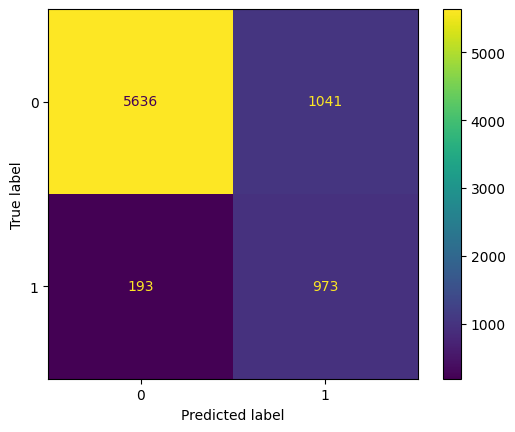

In [33]:

rf=RandomForestClassifier(random_state=1 , n_estimators=100, max_depth=10 , min_samples_split=3 , min_samples_leaf=3 , class_weight='balanced')
randomForestClassifier=Pipeline([('col_transformer',col_transformer),('randomForest',rf)])

randomForestClassifier.fit(xtrain, ytrain)

ypredicted_rf=randomForestClassifier.predict(xtest)



print(   'randomForestClassifier f1_score '  ,     f1_score(ytest, ypredicted_rf  , average='macro')    )

print('Classification Report')

print(classification_report(ytest ,ypredicted_rf))

print('Confusion Matrix')

ConfusionMatrixDisplay.from_estimator(randomForestClassifier,xtest,ytest)


In [34]:
# from imblearn.pipeline import Pipeline 


# stratifiedKFold=StratifiedKFold(random_state=1 , shuffle=True)

# randomForestClassifier=RandomForestClassifier(random_state=1 ,n_estimators=100,class_weight='balanced', n_jobs=-1)

# rf=Pipeline([('col_transformer',col_transformer),('smote',smote),('rf',randomForestClassifier)])

# params={'rf__max_depth':[10,15],'rf__min_samples_split':[3,5],'rf__min_samples_leaf':[3,5]}

# rf_grid=GridSearchCV(rf,param_grid=params,n_jobs=-1,cv=stratifiedKFold)

# rf_grid.fit(xtrain,ytrain)

# print("Best Params",rf_grid.best_params_)

# rf_grid=rf_grid.best_estimator_

# ypred_rf_grid=rf_grid.predict(xtest)

# print(   ' rf_grid f1_score macro '  ,     f1_score(ytest, ypred_rf_grid  , average='macro')    )

# print('Classification Report')

# print(classification_report(ytest ,ypred_rf_grid))

# print('Confusion Matrix')

# ConfusionMatrixDisplay.from_estimator(rf_grid,xtest,ytest)







# Best Params {'rf__max_depth': 15, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3}
#  rf_grid f1_score macro  0.7654329463215757
# Classification Report
#               precision    recall  f1-score   support

#            0       0.95      0.89      0.92      6677
#            1       0.54      0.72      0.61      1166

#     accuracy                           0.87      7843
#    macro avg       0.74      0.80      0.77      7843
# weighted avg       0.89      0.87      0.87      7843



f1_Score xgb 0.7604463778020902
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      6677
           1       0.53      0.69      0.60      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.79      0.76      7843
weighted avg       0.88      0.86      0.87      7843

Confusion Matrix


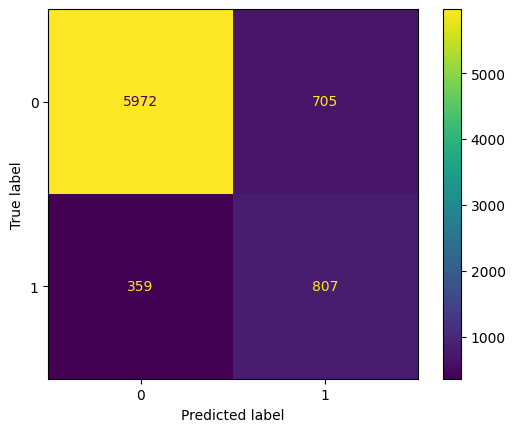

In [35]:

 
xgb=Pipeline([('col_transformer',col_transformer),('xgbb',XGBClassifier(scale_pos_weight=3))])
xgb.fit(xtrain , ytrain)
ypred_xgb=xgb.predict(xtest)

print('f1_Score xgb',f1_score(ytest , ypred_xgb , average='macro'))




print('Classification Report')

print(classification_report(ytest ,ypred_xgb))

print('Confusion Matrix')

ConfusionMatrixDisplay.from_estimator(xgb,xtest,ytest)



In [36]:
# param_grid = {
#     'xgbb__max_depth': [3, 5, 7],'xgbb__min_child_weight': [1, 3, 5],'xgbb__gamma': [ 0.2,0.3],'xgbb__learning_rate': [0.01, 0.1, 0.2],
    
# }

# cv_strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# xgb=Pipeline([('col_transformer',col_transformer),('xgbb',XGBClassifier(scale_pos_weight=3))])

# grid_xgb = GridSearchCV(xgb,param_grid=param_grid,scoring='f1_macro',cv=cv_strat,verbose=1,n_jobs=-1)

# grid_xgb.fit(xtrain,ytrain)

# print("Best Params",grid_xgb.best_params_)

# grid_xgb=grid_xgb.best_estimator_

# ypred_grid_xgb=grid_xgb.predict(xtest)

# print(   ' grid_xgb f1_score macro '  ,     f1_score(ytest, ypred_grid_xgb , average='macro')    )

# print('Classification Report')

# print(classification_report(ytest ,ypred_grid_xgb))

# print('Confusion Matrix')

# ConfusionMatrixDisplay.from_estimator(grid_xgb,xtest,ytest)




DecisionTreeClassifier f1_score macro 0.7170722811039821
------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      6677
           1       0.43      0.75      0.55      1166

    accuracy                           0.82      7843
   macro avg       0.69      0.79      0.72      7843
weighted avg       0.87      0.82      0.83      7843


------------------------------------------------------------------------------------
Confusion Matrix



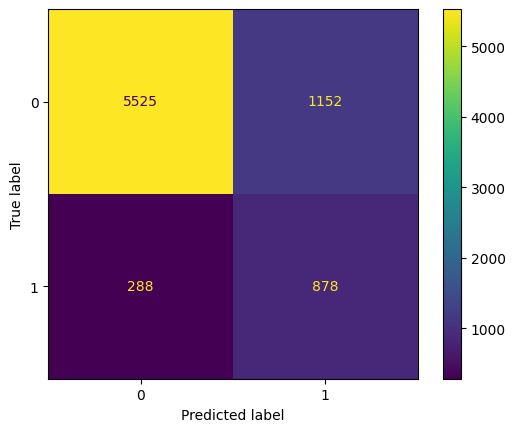

In [37]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=1 ,max_depth=15 , min_samples_split=4 , min_samples_leaf=5 , class_weight='balanced' )
dtc=Pipeline([('col_transformer',col_transformer),('dt',dt)])
dtc.fit(xtrain , ytrain)
ypred_dtc=dtc.predict(xtest)
print('')

print('DecisionTreeClassifier f1_score macro',f1_score(ytest, ypred_dtc , average='macro'))
print('------------------------------------------------------------------------------------')
print('')

print('Classification Report')
print(classification_report(ytest ,ypred_dtc))
print('')
print('------------------------------------------------------------------------------------')
print('Confusion Matrix')
print('')
ConfusionMatrixDisplay.from_estimator(dtc,xtest,ytest)





RUSBoostClassifier f1_score macro 0.7726970750847155
------------------------------------------------------------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      6677
           1       0.53      0.77      0.63      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.83      0.77      7843
weighted avg       0.89      0.86      0.87      7843


------------------------------------------------------------------------------------
Confusion Matrix



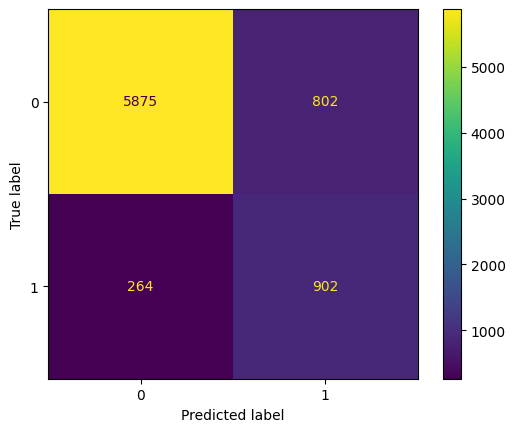

In [38]:
from imblearn.ensemble import RUSBoostClassifier
rus=RUSBoostClassifier(estimator=dt , n_estimators=150,learning_rate=1,sampling_strategy='auto' , random_state=1)
rus_clf=Pipeline([('col_transformer',col_transformer),('rus',rus)])

rus_clf.fit(xtrain , ytrain)
ypred_rus=rus_clf.predict(xtest)
print('')

print('RUSBoostClassifier f1_score macro',f1_score(ytest, ypred_rus , average='macro'))
print('------------------------------------------------------------------------------------')
print('')
print('Classification Report')
print(classification_report(ytest ,ypred_rus))
print('')
print('------------------------------------------------------------------------------------')
print('Confusion Matrix')
print('')
ConfusionMatrixDisplay.from_estimator(rus_clf,xtest,ytest)




In [39]:
# param={'rus__n_estimators':[100,150,200],'rus__replacement': [True, False]}
# cv_strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
# rus_clf=Pipeline([('col_transformer',col_transformer),('rus',RUSBoostClassifier(estimator=dt,learning_rate=1,sampling_strategy='auto' , random_state=1))])
# grid_rus = GridSearchCV(rus_clf,param_grid=param,scoring='f1_macro',cv=cv_strat,verbose=1,n_jobs=-1)
# grid_rus.fit(xtrain,ytrain)

# print("Best Params",grid_rus.best_params_)

# grid_rus=grid_rus.best_estimator_

# ypred_grid_rus=grid_rus.predict(xtest)

# print(' grid_xgb f1_score macro ',f1_score(ytest, ypred_grid_rus , average='macro')    )
# print('Classification Report')
# print(classification_report(ytest ,ypred_grid_rus))
# print('Confusion Matrix')
# ConfusionMatrixDisplay.from_estimator(grid_rus,xtest,ytest)








# Fitting 10 folds for each of 6 candidates, totalling 60 fits
# Best Params {'rus__n_estimators': 200, 'rus__replacement': False}
#  grid_xgb f1_score macro  0.7725800616817236
# Classification Report
#               precision    recall  f1-score   support

#            0       0.96      0.88      0.92      6677
#            1       0.53      0.76      0.63      1166

#     accuracy                           0.87      7843
#    macro avg       0.74      0.82      0.77      7843
# weighted avg       0.89      0.87      0.87      7843


SVC f1_score macro 0.7422090174290883

------------------------------------------------------------------

Classification Report SVC

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      6677
           1       0.47      0.78      0.59      1166

    accuracy                           0.84      7843
   macro avg       0.71      0.81      0.74      7843
weighted avg       0.88      0.84      0.85      7843

------------------------------------------------------------------

Confusion Matrix SVC


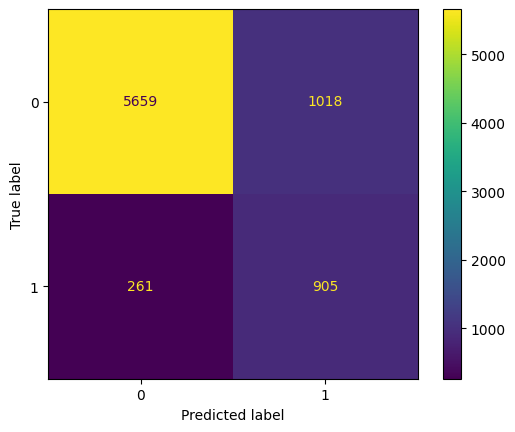

In [40]:
from sklearn.svm import SVC
svc=SVC(random_state=1 ,class_weight='balanced')
svc=Pipeline([('col_transformer',col_transformer),('svc',svc)])
svc.fit(xtrain , ytrain)
ypred_svc=svc.predict(xtest)
print("SVC f1_score macro" , f1_score(ytest , ypred_svc ,average='macro'))
print('')
print('------------------------------------------------------------------')
print('')
print('Classification Report SVC')
print('')
print(classification_report(ytest , ypred_svc))
print('------------------------------------------------------------------')
print('')
print('Confusion Matrix SVC')
ConfusionMatrixDisplay.from_estimator(svc,xtest,ytest)

# Light gbm


[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
lgm f1_score macro 0.7712869063049196

------------------------------------------------------------------

Classification Report lgm

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      6677
           1       0.52      0.78      0.63      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.83      0.77      7843
weighted avg       0.89      0.86     

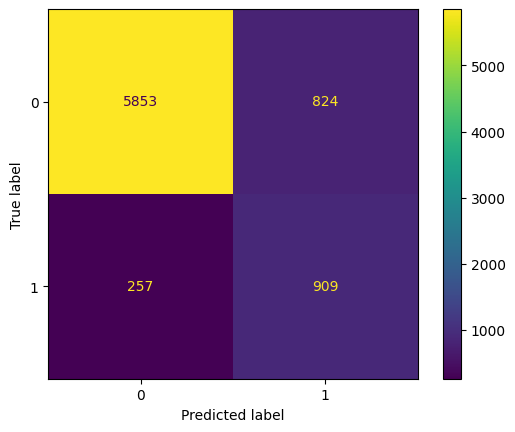

In [41]:
from lightgbm import LGBMClassifier
lgm=LGBMClassifier(random_state=42,n_jobs=-1,objective='binary',scale_pos_weight=3,colsample_bytree=1,n_estimators=100)
lgm=Pipeline([('col_transformer',col_transformer),('lgm',lgm)])
lgm.fit(xtrain , ytrain)
ypred_lgm=lgm.predict(xtest)
print("lgm f1_score macro" , f1_score(ytest , ypred_lgm ,average='macro'))
print('')
print('------------------------------------------------------------------')
print('')
print('Classification Report lgm')
print('')
print(classification_report(ytest , ypred_lgm))
print('------------------------------------------------------------------')
print('')
print('Confusion Matrix SVC')
ConfusionMatrixDisplay.from_estimator(lgm,xtest,ytest)

Best Params {'lgm__learning_rate': 0.05, 'lgm__num_leaves': 31, 'lgm__subsample': 0.7}
 grid_lgm f1_score macro  0.7724981379575366
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      6677
           1       0.52      0.79      0.63      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.83      0.77      7843
weighted avg       0.89      0.86      0.87      7843

Confusion Matrix


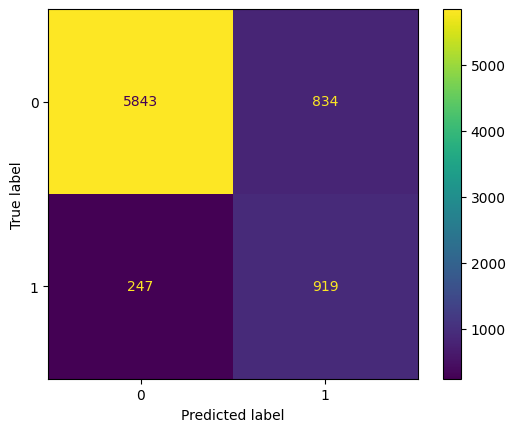

In [42]:
params = {
    'lgm__num_leaves': [31, 50, 70, 100],'lgm__learning_rate': [0.01, 0.05, 0.1],'lgm__subsample': [0.7, 0.8, 0.9]}

lgm=LGBMClassifier(random_state=42,n_jobs=-1,objective='binary',scale_pos_weight=3,verbose=0)
lgm=Pipeline([('col_transformer',col_transformer),('lgm',lgm)])
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_lgm = GridSearchCV(lgm,param_grid=params,scoring='f1_macro',cv=cv_strat,verbose=0,n_jobs=-1)
grid_lgm.fit(xtrain,ytrain)

print("Best Params",grid_lgm.best_params_)

grid_lgm=grid_lgm.best_estimator_

ypred_grid_lgm=grid_lgm.predict(xtest)

print(' grid_lgm f1_score macro ',f1_score(ytest, ypred_grid_lgm , average='macro')    )
print('Classification Report')
print(classification_report(ytest ,ypred_grid_lgm))
print('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(grid_lgm,xtest,ytest)



In [43]:
# selection=random
# from sklearn.linear_model import LogisticRegression
# rsKF=RepeatedStratifiedKFold(random_state=1)
# log = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', random_state=1, max_iter=3000,n_jobs=-1 , C=0.01 )

# logistic=Pipeline([('col_transformer',col_transformer),('logistic',log)])

# logistic.fit(xtrain, ytrain)

# ypred_logistic=logistic.predict(xtest)

# print(   'logistic f1_score '  ,     f1_score(ytest, ypred_logistic  , average='macro')    )

# print('Classification Report')

# print(classification_report(ytest ,ypred_logistic))

# print('Confusion Matrix')

# ConfusionMatrixDisplay.from_estimator(logistic,xtest,ytest)



In [44]:
# from sklearn.neighbors import KNeighborsClassifier
# kneighborsClassifier=KNeighborsClassifier(n_jobs=-1 , n_neighbors=5)
# knn=Pipeline([('col_transformer',col_transformer),('kneighborsClassifier',kneighborsClassifier)])


# knn.fit(xtrain , ytrain)

# ypred_knn=knn.predict(xtest)


# print(   'knn f1_score '  ,     f1_score(ytest, ypred_knn  , average='macro')    )

# print('Classification Report')

# print(classification_report(ytest ,ypred_knn))

# print('Confusion Matrix')

# ConfusionMatrixDisplay.from_estimator(knn,xtest,ytest)




In [45]:
y_pred_submission=grid_lgm.predict(test)
ypred_submission_final = pd.Series(y_pred_submission).replace({0: 'no', 1: 'yes'})

submission=pd.DataFrame({'id': np.arange(0,len(test)), 'target': ypred_submission_final})

submission.to_csv('submission.csv',index=False)